# Zernike circle polynomials
The [Zernike circle polynomials](https://en.wikipedia.org/wiki/Zernike_polynomials), $U^\ell_n(\varrho, \vartheta)$, are orthonormal polynomials inside a unitary circle, which are related to low order aberration functions. The wavefront (aberration) distribution, $W(\varrho, \vartheta)$, is nothing more than a combination of coefficients and sum of the polynomials,
$$ W(\varrho, \vartheta) = \sum_n\sum_\ell K^\ell_n U^\ell_n(\varrho, \vartheta) $$


In [1]:
# Adjustin notebook
%reload_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
# importing math and plot packages
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from scipy.constants import golden  # Golden ratio
from astropy.io import ascii
from pyoof import zernike, cart2pol, aperture

# Plotting parameters, to make it nicer :) 
matplotlib.rcParams['figure.figsize'] = (golden * 7, 7)
matplotlib.rcParams['figure.subplot.wspace'] = 0.5
matplotlib.rcParams['figure.subplot.left'] = 0.1
matplotlib.rcParams['figure.subplot.bottom'] = 0.2
matplotlib.rcParams['figure.subplot.right'] = 1
matplotlib.rcParams['figure.subplot.top'] = 0.85
matplotlib.rcParams['axes.labelsize'] = 15
matplotlib.rcParams['axes.titlesize'] = 15

Up to order $n=5$ there are $21$ Zernike circle polynomials, according to the rule $\frac{1}{2}(n+1)(n+2)$. The Zernike circle polynomials are subdivided in an angular and radial section. The radial are known as radial polynomials, $R_n^\ell(\varrho)$. You can import the radial polynomials from the `zernike.R` module.

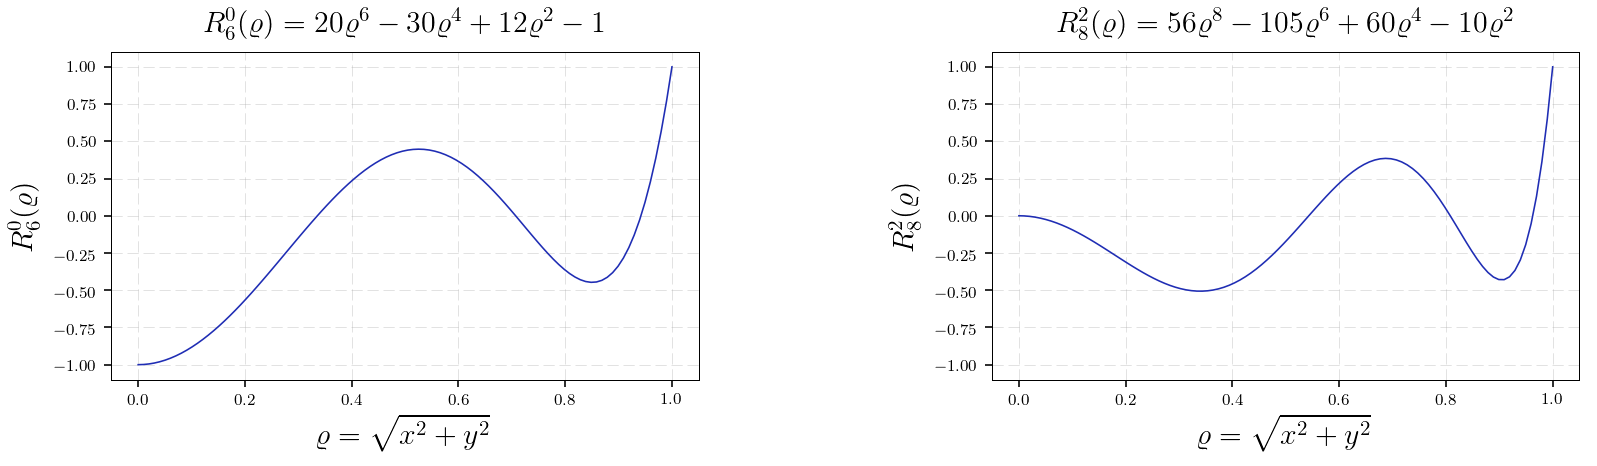

In [3]:
# Radial polynomials example
x_data = np.linspace(0, np.sqrt(.5), 100)
y_data = np.linspace(0, np.sqrt(.5), 100)
rho = np.sqrt(x_data ** 2 + y_data ** 2)

fig, ax = plt.subplots(ncols=2, figsize=(golden * 7, 7 / 2))

ax[0].plot(rho, zernike.R(0, 6, rho=rho))
ax[1].plot(rho, zernike.R(2, 8, rho=rho))
ax[0].set_title('$R^0_6(\\varrho)=20\\varrho^6-30\\varrho^4+12\\varrho^2-1$')
ax[0].set_ylabel('$R^0_6(\\varrho)$')
ax[1].set_title(
    '$R^2_8(\\varrho)=56\\varrho^8-105\\varrho^6+60\\varrho^4-10\\varrho^2$'
    )
ax[1].set_ylabel('$R^2_8(\\varrho)$')
for ax_ in ax:
    ax_.set_xlabel('$\\varrho=\sqrt{x^2+y^2}$')
    ax_.set_ylim(-1.1, 1.1)

plt.show()

Then depending on its angular value, the Zernike circle polynomials can be computed, 

$$ U^{\ell}_n(\varrho, \vartheta) = R^{|\ell|}_n(\varrho, \vartheta)\cos|\ell|\vartheta \qquad \text{or} \qquad U^{\ell}_n(\varrho, \vartheta) = R^{|\ell|}_n(\varrho, \vartheta)\sin|\ell|\vartheta  $$

with $0\leq\ell$ or $\ell<0$, respectively. The module `zernike.U` has already loaded the raldia polynomials, then it is possible to compute several polynomials orders at a time.

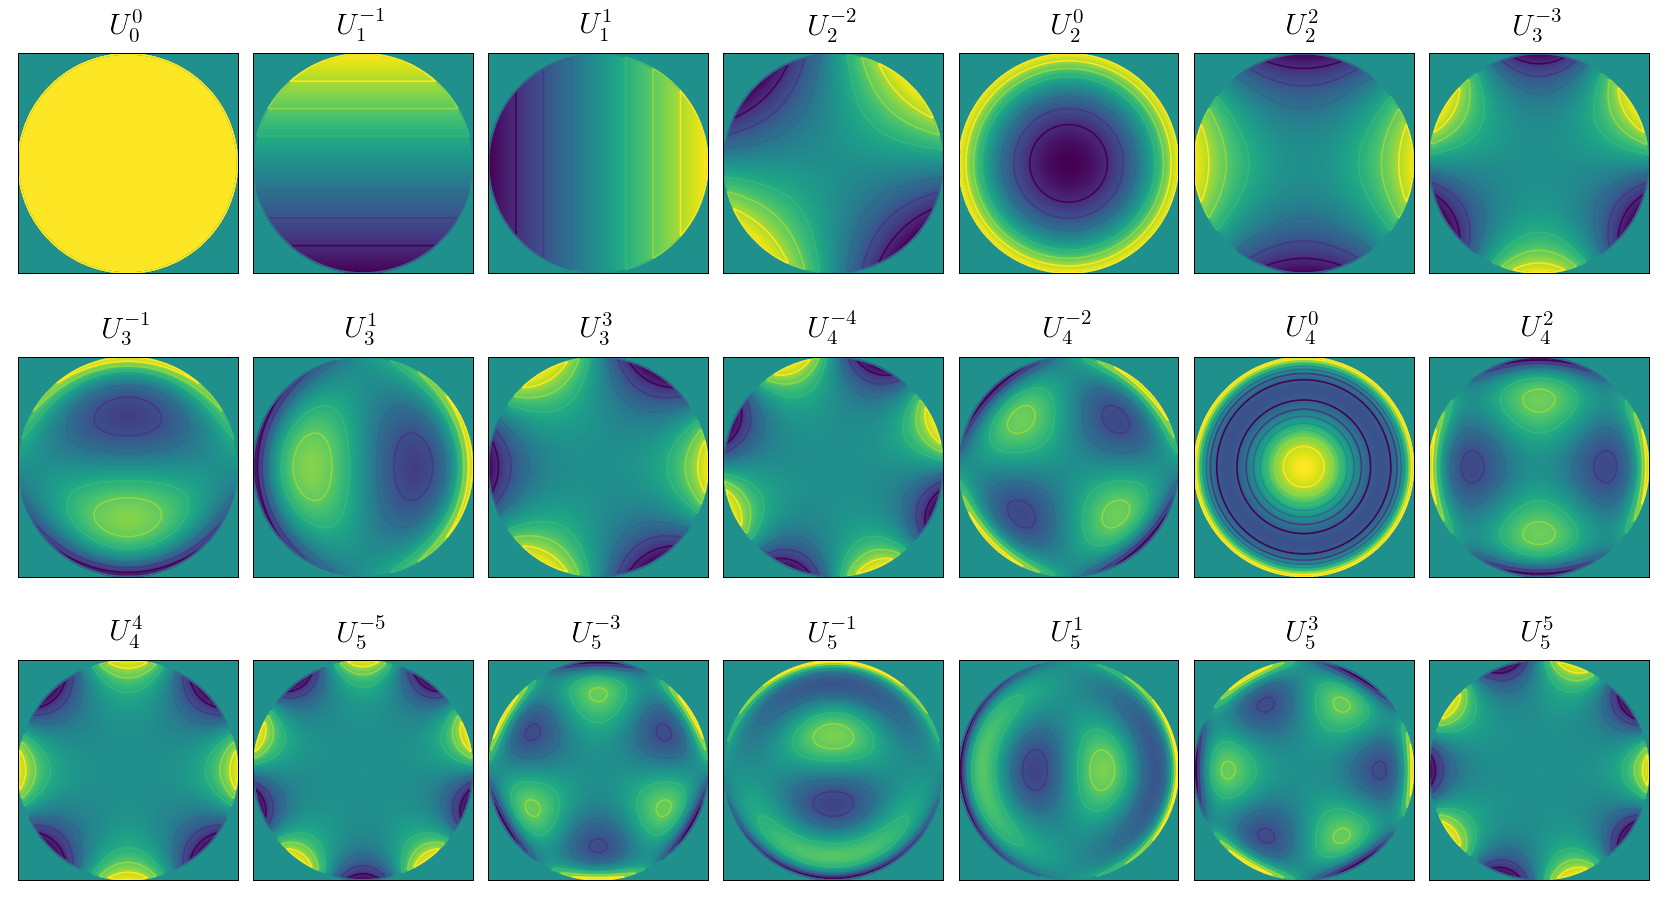

In [4]:
pr = 50  # primary dish radius
y_data = np.linspace(-pr, pr, 500)
x_data = np.linspace(-pr, pr, 500)
x_grid, y_grid = np.meshgrid(x_data, y_data)


# Zernike Pyramid
def circle(x, y, R=50):
    circ = np.zeros(x.shape)  # or y.shape
    circ[x ** 2 + y ** 2 <= R ** 2] = 1
    return circ


circ = circle(x_grid, y_grid)
r, t = cart2pol(x_grid, y_grid)  # Chaning values for U and phi
# if not change weird things happen to the plots (inversion at half)

r_norm = r / 50  # Normalization R(m, n)(r=1) = 1

n_max = 5  # Max number n for the Zernike polynomials
ln = [(j, i) for i in range(0, n_max + 1) for j in range(-i, i + 1, 2)]
L = np.array(ln)[:, 0]
N = np.array(ln)[:, 1]
n_plots = len(L)

fig, axes = plt.subplots(nrows=3, ncols=7)
fig.subplots_adjust(left=0, bottom=0, right=1, top=.9, wspace=.07, hspace=.01)

ax = axes.flat
lev = np.linspace(0, 10, 0.01)

for i in range(n_plots):

    _U = zernike.U(L[i], N[i], t, r_norm) * circ
    im = ax[i].imshow(_U, vmin=-1, vmax=1)

    contours = ax[i].contour(_U, 8)
    ax[i].set_title('$U^{' + str(L[i]) + '}_{' + str(N[i]) + '}$')
    # ax[i].set_aspect('equal')

    ax[i].xaxis.set_major_formatter(plt.NullFormatter())
    ax[i].yaxis.set_major_formatter(plt.NullFormatter())
    ax[i].xaxis.set_ticks_position('none')
    ax[i].yaxis.set_ticks_position('none')
    ax[i].grid(False)
    
plt.show()

What is important for the radio telescope is the phase distribution, which is in fact related to the aberration, hence the Zernike circle polynomials. The phase error, $\varphi$ is expressed as,

$$ \varphi(x, y)=2\pi W(x, y) $$

From the `pyoof` package the values for the Zernike coefficients, $K^\ell_n$, have to include the factor $2\pi$. Now it follows a real example from observed data at the Effeslberg telescope. The phase error needs the `K_coeff` array as an input.

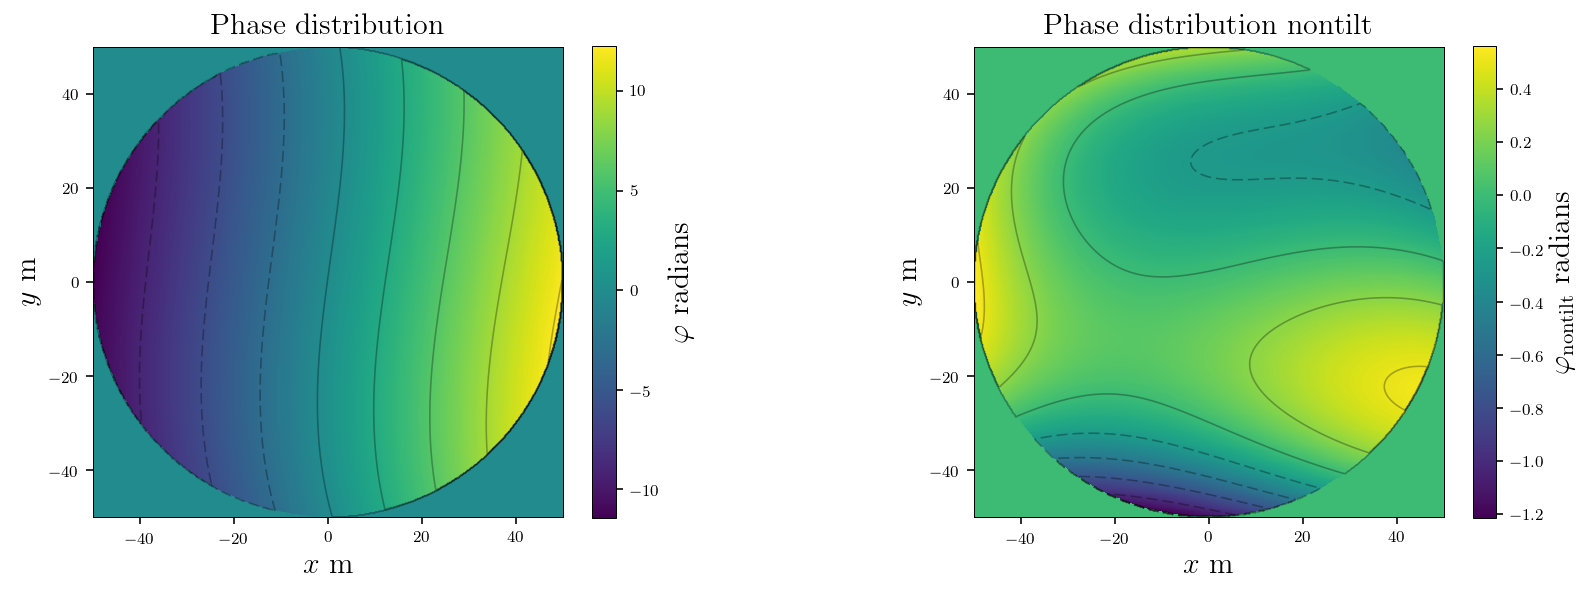

In [7]:
# importing data
K_coeff_n3 = ascii.read('examples/fitpar_n3.dat')['parfit'][4:]

# Wavefront (aberration) distribution -> phase error
W_tilt = aperture.wavefront(rho=r_norm, theta=t, K_coeff=K_coeff_n3) * 2 * np.pi

# Removing the tilt term
K_coeff_n3[1] = 0
K_coeff_n3[2] = 0
W_notitlt = aperture.wavefront(rho=r_norm, theta=t, K_coeff=K_coeff_n3) * 2 * np.pi

# Giving the circle shape
circ_mask = (x_grid ** 2 + y_grid ** 2 > pr ** 2)
extent = [-pr, pr] * 2
shrink = 0.72

W_tilt[circ_mask] = 0
W_notitlt[circ_mask] = 0

fig, ax = plt.subplots(ncols=2)

im0 = ax[0].imshow(W_tilt, extent=extent)
ax[0].contour(x_grid, y_grid, W_tilt, colors='k', alpha=0.3)
ax[0].set_title('Phase distribution')

cb0 = fig.colorbar(im0, ax=ax[0], shrink=shrink)
cb0.ax.set_ylabel('$\\varphi$ radians')

im1 = ax[1].imshow(W_notitlt, extent=extent)
ax[1].contour(x_grid, y_grid, W_notitlt, colors='k', alpha=0.3)
ax[1].set_title('Phase distribution nontilt')

cb1 = fig.colorbar(im1, ax=ax[1], shrink=shrink)
cb1.ax.set_ylabel('$\\varphi_\mathrm{nontilt}$ radians')

for _ax in ax:
    _ax.grid('off')
    _ax.set_xlabel('$x$ m')
    _ax.set_ylabel('$y$ m')
    
plt.show()

The difference between the two phase error distributions lays over the [tilt](https://en.wikipedia.org/wiki/Tilt_(optics) terms. The tilt in optics is given by a first order radial term, $\varrho$, and quantifies the avergage slope in the $x$ and $y$ directions. For the phase telescope purposes these terms will be removed, and correspond to the coefficiest first order, $K^{-1}_1$ and $K^1_1$, simply set to be zero. These errors are related to the telescope's pointing and become irrelevant to the OOF holography analysis.